# Compare different scenarios 

In [5]:
import sys
sys.path.append('G:/My Drive/Research/adaptation_abm/code')
import model.model as mod
import model.base_inputs as inp
import plot.scenario_comparison as plt_sc
import plot.single_run as plt
import imp
import numpy as np
import pickle
import copy
imp.reload(plt)
imp.reload(mod)

<module 'model.model' from 'G:/My Drive/Research/adaptation_abm/code\\model\\model.py'>

## Define scenarios 

In [17]:
# load default params
inp_base = inp.compile()
#### OR ####
# load from POM experiment
f = '../../outputs/POM/input_params_10000.pkl'
inp_base = pickle.load(open(f, 'rb'))

# manually specify some variables (common to all scenarios)
inp_base['model']['T'] = 100
inp_base['model']['n_agents'] = 200
inp_base['model']['exp_name'] = 'scenario_compare'
# inp_base['agents']['cash_req_mean'] = 17261/2
inp_base['agents']['adap_type'] = 'affording'

# define some scenarios
scenarios = {
    'baseline' : {'model' : {'adaptation_option' : 'none'}},
    'insurance' : {'model' : {'adaptation_option' : 'insurance'}},
    'cover_crop' : {'model' : {'adaptation_option' : 'cover_crop'}},
}

## Run the model

In [18]:
mods = {}
for name, vals in scenarios.items():
    # change the params
    params = copy.copy(inp_base)
    for k, v in vals.items():
        for k2, v2 in v.items():
            params[k][k2] = v2
    
    # initialize and run model
    m = mod.Model(params)
    for t in range(m.T):
        m.step()
    mods[name] = m

G:/My Drive/Research/adaptation_abm/code\model\land.py:125: RuntimeWarning: invalid value encountered in true_divide
  self.nutrient_factors[t] = self.yields[t] / self.yields_unconstrained[t]


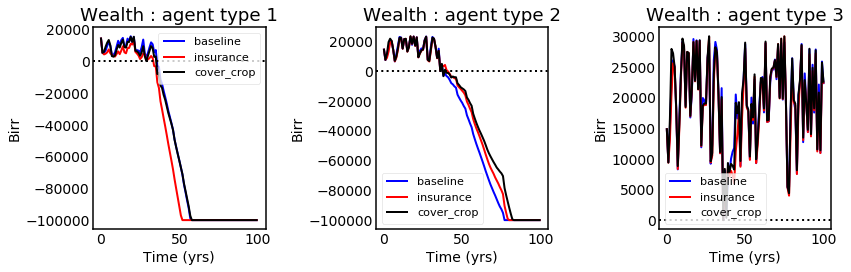

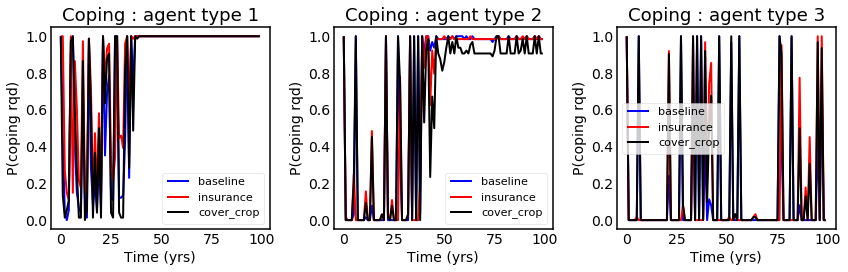

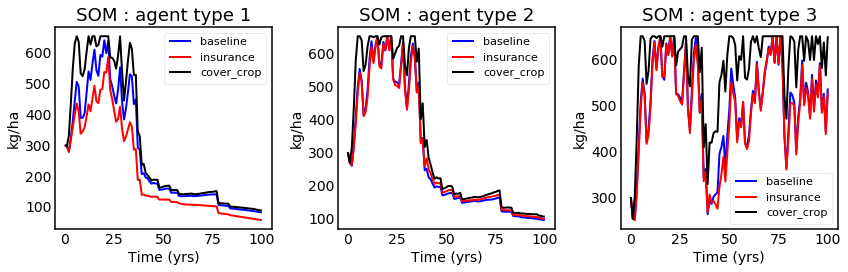

In [20]:
imp.reload(plt_sc)
plt_sc.main(mods, save=False)